In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [14]:
# Step 2: Load the Dataset
data = pd.read_csv("/Users/book_kuno/Downloads/DDoS 2018/02-21-2018.csv")
print(data.head())
# Randomly sample 1/10 of the data
data = data.sample(frac=0.1, random_state=42)  # frac=0.1 means 10%, random_state ensures reproducibility
# Preview the sampled data
print(data.head())

   Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
0        80         6  21/02/2018 08:33:25          37953             5   
1       500        17  21/02/2018 08:33:06      117573474             3   
2       500        17  21/02/2018 08:33:06      117573474             3   
3       500        17  21/02/2018 08:33:11       99743998             5   
4       500        17  21/02/2018 08:33:11       99743999             5   

   Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
0             3              135              127              135   
1             0             1500                0              500   
2             0             1500                0              500   
3             0             2500                0              500   
4             0             2500                0              500   

   Fwd Pkt Len Min  ...  Fwd Seg Size Min  Active Mean  Active Std  \
0                0  ...                32          0.0    

In [15]:
# Step 3: Preprocess the Data
data.columns = data.columns.str.strip()
data = data.dropna()
# Encode the target column ('Label')
encoder = LabelEncoder()
data['Label'] = encoder.fit_transform(data['Label'])
# Select only numeric columns for scaling
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('Label')  # Exclude the target column
# Check for infinite or extremely large values
data[numeric_columns] = data[numeric_columns].replace([np.inf, -np.inf], np.nan)
data = data.dropna(subset=numeric_columns)
# Scale the numeric feature columns
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
X = data[numeric_columns]
y = data['Label']

In [16]:
# Step 4: Split the Dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [17]:
# Step 5: Train the Linear SVM
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [18]:
# Step 6: Validate the Model
y_val_pred = svm_model.predict(X_val)
print("Validation Results")
print(classification_report(y_val, y_val_pred))

Validation Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5219
           1       1.00      1.00      1.00     10474
           2       1.00      1.00      1.00        36

    accuracy                           1.00     15729
   macro avg       1.00      1.00      1.00     15729
weighted avg       1.00      1.00      1.00     15729



In [19]:
# Step 7: Hyperparameter Tuning (Optional)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear']
}
grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 0.1, 'kernel': 'linear'}


In [20]:
# Step 8: Test the Model
y_test_pred = svm_model.predict(X_test)
print("Test Results")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Test Results
[[ 5426     0     2]
 [    0 10278     0]
 [    0     0    23]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5428
           1       1.00      1.00      1.00     10278
           2       0.92      1.00      0.96        23

    accuracy                           1.00     15729
   macro avg       0.97      1.00      0.99     15729
weighted avg       1.00      1.00      1.00     15729

Accuracy: 0.9998728463347956


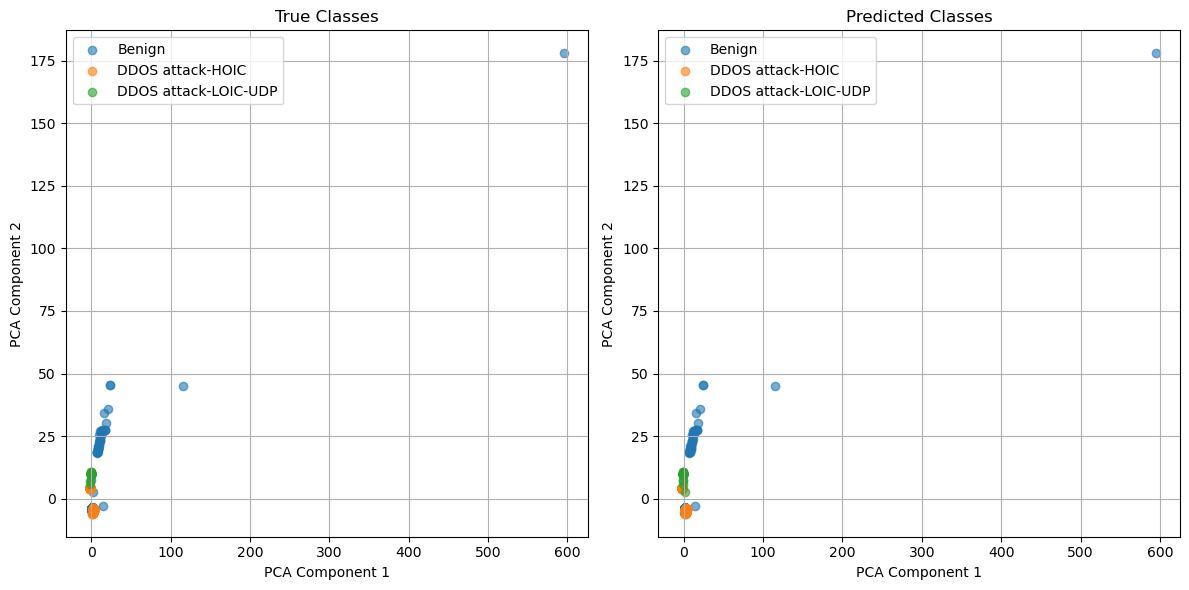

In [21]:
# Step 9: Dimensionality Reduction for Visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Map class labels back to their original names
class_labels = dict(zip(range(len(encoder.classes_)), encoder.classes_))
y_test_names = y_test.map(class_labels)
y_test_pred_names = pd.Series(y_test_pred).map(class_labels)

# Plot the true classes
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for label in np.unique(y_test_names):
    plt.scatter(X_test_pca[y_test_names == label, 0], 
                X_test_pca[y_test_names == label, 1], 
                label=label, alpha=0.6)
plt.title("True Classes")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(loc="best")
plt.grid()

# Plot the predicted classes
plt.subplot(1, 2, 2)
for label in np.unique(y_test_pred_names):
    plt.scatter(X_test_pca[y_test_pred_names == label, 0], 
                X_test_pca[y_test_pred_names == label, 1], 
                label=label, alpha=0.6)
plt.title("Predicted Classes")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(loc="best")
plt.grid()

plt.tight_layout()
plt.show()